## Try various entropy sampling (active learning technique) with embedding model 2

### Let's use embedding model 2, trained on only 500 datapoints

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn import preprocessing 
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
import tensorflow as tf

data_dir = "../../data/"
train_vals_df = pd.read_csv(os.path.join(data_dir, "train_values.csv"))
train_labels_df = pd.read_csv(os.path.join(data_dir, "train_labels.csv"))

# get categorical data
X1 = train_vals_df[["geo_level_1_id", "geo_level_2_id", "position", "foundation_type", "roof_type", "ground_floor_type", "other_floor_type", "plan_configuration", "legal_ownership_status"]].to_numpy()

enc = OrdinalEncoder()
enc.fit(X1)
X1 = enc.transform(X1)

## get numerical data
df = train_vals_df[[
'count_floors_pre_eq',
'age',
'area_percentage',
'height_percentage']]

# normalize numerical data
min_max_scaler = preprocessing.MinMaxScaler()
X2 = min_max_scaler.fit_transform(df.values)


# get labels

y = train_labels_df["damage_grade"].to_numpy()
y = np.eye(3)[y-1]

X = np.concatenate((X1,X2), axis = 1)
# X = np.asarray(X).astype('float32')

In [2]:
rng = np.random.RandomState(7)
perm = rng.permutation(range(len(X)))
X_rand = X[perm]
y_rand = y[perm]

seedSize = 500
X_train = X[:seedSize ]
y_train = y[:seedSize ]

# unlabeled dataset
X_u = X[seedSize :int(.7*len(X))]
y_u = y[seedSize :int(.7*len(X))]

X_val = X[int(.7*len(X)):int(.85*len(X))]
y_val = y[int(.7*len(X)):int(.85*len(X))]
X_test = X[int(.85*len(X)):]
y_test = y[int(.85*len(X)):]

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense, Embedding

checkpoint_filepath = '/tmp/saved_models'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True)

## Creating the layers
batch_size = 2048
input = Input(shape=(13,)) 
embedding0 = Embedding(31, 2)(input[:,0]) # geo id 1
embedding1 = Embedding(1428, 2)(input[:,1]) # geo id 2
embedding2 = Embedding(4, 2)(input[:,2]) # position
embedding3 = Embedding(5, 2)(input[:,3]) # foundation type
embedding4 = Embedding(3, 2)(input[:,4]) # roof type
embedding5 = Embedding(5, 2)(input[:,5]) # ground floor type
embedding6 = Embedding(4, 2)(input[:,6]) # other floor type
embedding7 = Embedding(10, 3)(input[:,7]) # plan configuration
embedding8 = Embedding(4, 2)(input[:,8]) # legal ownership status
Layer_1 = Dense(20, activation="relu")(tf.concat([embedding0,embedding1,embedding2,embedding3,embedding4,embedding5,embedding6, embedding7, embedding8, input[:,9:]], 1))
# Layer_1 = Dense(20, activation="relu")(tf.concat([embedding0,embedding1,embedding2,embedding3,embedding4, input[:,5:]], 1))
Layer_2 = Dense(15, activation="relu")(Layer_1)
Layer_3 = Dense(10, activation="relu")(Layer_2)
output_layer= Dense(3, activation="softmax")(Layer_3)

model = tf.keras.Model(inputs=input, outputs=output_layer, name="emb_model")
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='CategoricalCrossentropy', metrics=['CategoricalAccuracy'])
history = model.fit(X_train, y_train, epochs=100, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[model_checkpoint_callback])

2022-04-15 22:03:39.384528: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-15 22:03:39.385199: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-15 22:03:39.492859: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 1.1031 - categorical_accuracy: 0.1820 - val_loss: 1.1029 - val_categorical_accuracy: 0.1997
Epoch 2/100
1/1 [==============================] - 0s 46ms/step - loss: 1.1029 - categorical_accuracy: 0.1880 - val_loss: 1.1027 - val_categorical_accuracy: 0.2069
Epoch 3/100
1/1 [==============================] - 0s 52ms/step - loss: 1.1027 - categorical_accuracy: 0.1980 - val_loss: 1.1025 - val_categorical_accuracy: 0.2151
Epoch 4/100
1/1 [==============================] - 0s 54ms/step - loss: 1.1024 - categorical_accuracy: 0.2120 - val_loss: 1.1023 - val_categorical_accuracy: 0.2229
Epoch 5/100
1/1 [==============================] - 0s 50ms/step - loss: 1.1022 - categorical_accuracy: 0.2120 - val_loss: 1.1021 - val_categorical_accuracy: 0.2298
Epoch 6/100
1/1 [==============================] - 0s 49ms/step - loss: 1.1020 - categorical_accuracy: 0.2160 - val_loss: 1.1019 - val_categorical_accuracy: 0.2374
Epoch 7/100
1/1 [=

## Margin Sampling and Entropy Sampling: 
### Margin: Go through unlabeled data and pick samples that the model has the smallest difference between first and second most probable class
### Entropy: Go through unlabeled data and pick samples that the model has the largest prob distribution difference from true

In [4]:
from scipy.stats import entropy
def update_training_data(model, X_train, y_train, X_u, y_u, new_data_size = 1000, method = "margin_sampling"):
    # Params:
    # model is currently trained model
    # X_train and y_train are current training data
    # X_u and y_u are current unlabeled data to select new training data from

    # returns:
    # new X_train, y_train, X_u, y_u 
    if method == "margin_sampling":
        preds = model.predict(X_u)
        margins = []
        for pred in preds:
            sorted = pred[np.argsort(pred)]
            margins.append(sorted[-1] - sorted[-2]) 

        margins = np.array(margins)

        selected_idxs = np.argpartition(margins, new_data_size)[:new_data_size]
        not_selected_idxs = np.array(list(set(range(len(X_u))) - set(selected_idxs)))

        X_train = np.concatenate((X_train, X_u[selected_idxs]), axis = 0)
        y_train = np.concatenate((y_train, y_u[selected_idxs]), axis = 0)
        X_u = X_u[not_selected_idxs]
        y_u = y_u[not_selected_idxs]
    

        return X_train, y_train, X_u, y_u


    elif method == "entropy_sampling":
        preds = model.predict(X_u)
        entrops = []
        for idx, pred in enumerate(preds):
            entrop = entropy(pred)
            entrops.append(entrop)

        entrops = np.array(entrops)

        selected_idxs = np.argpartition(entrops, -new_data_size)[-new_data_size:]
        not_selected_idxs = np.array(list(set(range(len(X_u))) - set(selected_idxs)))

        X_train = np.concatenate((X_train, X_u[selected_idxs]), axis = 0)
        y_train = np.concatenate((y_train, y_u[selected_idxs]), axis = 0)
        X_u = X_u[not_selected_idxs]
        y_u = y_u[not_selected_idxs]
    

        return X_train, y_train, X_u, y_u

    else:
        raise NotImplementedError("The method {} has not been implemented".format(method))

## Run entropy sampling

In [5]:
import time
val_accs = []
while history.history["val_categorical_accuracy"][-1] < .675:
    X_train, y_train, X_u, y_u = update_training_data(model, X_train, y_train, X_u, y_u, new_data_size = 500, method = "entropy_sampling")
    history = model.fit(X_train, y_train, epochs=100, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[model_checkpoint_callback])
    print("Trained on {} unique samples total".format(len(X_train)))
    val_acc = history.history["val_categorical_accuracy"][-1]
    print("New val accuracy is {}".format(val_acc))
    val_accs.append(val_acc)
    time.sleep(3)

Epoch 1/100
1/1 [==============================] - 0s 77ms/step - loss: 1.0903 - categorical_accuracy: 0.4190 - val_loss: 1.0816 - val_categorical_accuracy: 0.5536
Epoch 2/100
1/1 [==============================] - 0s 50ms/step - loss: 1.0901 - categorical_accuracy: 0.4230 - val_loss: 1.0814 - val_categorical_accuracy: 0.5546
Epoch 3/100
1/1 [==============================] - 0s 47ms/step - loss: 1.0898 - categorical_accuracy: 0.4310 - val_loss: 1.0811 - val_categorical_accuracy: 0.5567
Epoch 4/100
1/1 [==============================] - 0s 48ms/step - loss: 1.0896 - categorical_accuracy: 0.4340 - val_loss: 1.0809 - val_categorical_accuracy: 0.5586
Epoch 5/100
1/1 [==============================] - 0s 50ms/step - loss: 1.0893 - categorical_accuracy: 0.4430 - val_loss: 1.0807 - val_categorical_accuracy: 0.5614
Epoch 6/100
1/1 [==============================] - 0s 52ms/step - loss: 1.0891 - categorical_accuracy: 0.4550 - val_loss: 1.0804 - val_categorical_accuracy: 0.5621
Epoch 7/100
1/1 

## Show the model's performance increase during entropy sampling

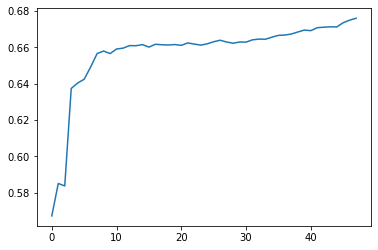

In [6]:
import matplotlib.pyplot as plt

plt.plot(val_accs)

## Test the model trained using entropy sampling

### Only 7500 points needed to reach .675 accuracy (if we randomly selected 7500 points, only .57 accuracy reached)

In [11]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
predictions = model.predict(X_test)
y_pred = []
y_true = []
for i,row in enumerate(predictions):
  y_pred.append(np.argmax(row))
  y_true.append(np.argmax(y_test[i]))

f1_score(y_true, y_pred, average = 'micro')

0.6756030799928372